In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from collections import defaultdict # For easier subject counts
import operator
from tqdm.notebook import tqdm
import datetime
import re
import pickle
import random
# Optional: for better display in Jupyter
from IPython.display import display
from scipy.stats import truncnorm

In [2]:

def generate_master_timetables():
    """
    Generates and saves master academic timetables for all subject/year groups.
    """
    print("Step 1: Loading student data to identify all groups...")
    try:
        students_df = pd.read_csv('students_groups_social.csv')
    except FileNotFoundError:
        print("Error: 'students_groups_social.csv' not found. Please ensure the file is available.")
        return

    # Find all unique (Subject, Year) combinations from the student data
    unique_subject_years = students_df[['Subject', 'Year']].drop_duplicates().to_records(index=False)
    unique_subjects = students_df['Subject'].unique().tolist()
    
    print(f"Found {len(unique_subject_years)} unique subject/year combinations.")

    # --- Rule Generation ---
    # Categorize subjects to apply different rule templates
    stem_subjects = [s for s in unique_subjects if 'Eng' in s or 'Sci' in s or 'Math' in s or 'Comp' in s or 'Med' in s or 'Vet' in s]
    
    academic_rules = {}
    for subject, year in unique_subject_years:
        rule_key = (subject, year)
        # Default to Arts-style rules
        hours_per_day = 2
        days = [0, 2, 4] # Mon, Wed, Fri
        
        # STEM subjects have more contact hours
        if subject in stem_subjects:
            hours_per_day = 3
            days = [0, 1, 2, 3, 4] # Mon-Fri
            
        # Adjust hours based on year
        if year == 1:
            hours_per_day += 1 # More hours for first years
        elif year >= 3:
            hours_per_day -= 1 # Fewer formal lectures for later years
        
        academic_rules[rule_key] = {'hours': hours_per_day, 'days': days}

    print("Step 2: Generating a master timetable for each group...")
    NUM_TIMESTEPS = 4 * 7 * 24 #672
    master_timetables = {}
    lecture_hours_of_day = [9, 10, 11, 12, 14, 15, 16, 17] # Potential lecture slots

    for subject, year in unique_subject_years:
        rule_key = (subject, year)
        rule_details = academic_rules[rule_key]
        
        # Create a blank 672-hour schedule for this group
        schedule = ['Free'] * NUM_TIMESTEPS
        
        # Iterate through the 28 days of the simulation
        for day_num in range(28):
            current_datetime = datetime.datetime(2024, 10, 1) + datetime.timedelta(days=day_num)
            
            # Term starts Oct 9th, check if it's a valid lecture day
            if current_datetime.day >= 9 and current_datetime.weekday() in rule_details['days']:
                # Choose random available slots for the lectures on this day
                lecture_slots = np.random.choice(lecture_hours_of_day, rule_details['hours'], replace=False)
                
                for hour_slot in lecture_slots:
                    timestep_to_update = day_num * 24 + hour_slot
                    if timestep_to_update < NUM_TIMESTEPS:
                        schedule[timestep_to_update] = f"{subject} Lectures"
                        
        master_timetables[rule_key] = schedule
        
    print(f"Step 3: Saving {len(master_timetables)} master timetables to 'master_timetables.pkl'...")
    with open('master_timetables.pkl', 'wb') as f:
        pickle.dump(master_timetables, f)
        
    print("Done.")

def apply_master_timetables_efficiently():
    """
    Loads master timetables and applies them to students, creating the 
    final DataFrame in a single, high-performance operation.
    """
    print("Step 1: Loading prerequisite files...")
    try:
        with open('master_timetables.pkl', 'rb') as f:
            master_timetables = pickle.load(f)
        students_df = pd.read_csv('students_groups_social.csv')
    except FileNotFoundError as e:
        print(f"Error: A required file was not found. Please run the Part 1 script first. Missing: {e}")
        return

    print(f"Loaded {len(master_timetables)} master timetables and {len(students_df)} students.")
    
    NUM_TIMESTEPS = 4 * 7 * 24
    
    print("Step 2: Generating schedule data for all students in memory...")
    start_time = time.time()
    
    # This list will hold the schedule (as a list) for every student
    all_student_schedules = []

    # Iterate through each student to prepare their final schedule list
    for student_id, student_row in students_df.iterrows():
        # The default schedule is the student's college for all timesteps
        base_schedule = ['Free'] * NUM_TIMESTEPS
        
        rule_key = (student_row['Subject'], student_row['Year'])
        
        # If an academic timetable exists for them, apply it
        if rule_key in master_timetables:
            master_schedule = np.array(master_timetables[rule_key])
            # Use np.where to efficiently combine the base schedule with academic events
            final_schedule = np.where(master_schedule != 'Free', master_schedule, base_schedule)
            all_student_schedules.append(final_schedule.tolist())
        else:
            # Otherwise, their schedule is just the base schedule
            all_student_schedules.append(base_schedule)

    generation_time = time.time() - start_time
    print(f"Data generation complete in {generation_time:.2f} seconds.")

    print("Step 3: Creating the final DataFrame from the generated data (one operation)...")
    start_time = time.time()
    
    # Create the DataFrame in a single, efficient call
    timestep_columns = [f'T_{t}' for t in range(NUM_TIMESTEPS)]
    student_schedules_df = pd.DataFrame(
        data=all_student_schedules, 
        index=students_df.index, 
        columns=timestep_columns
    )
    student_schedules_df.index.name = 'StudentID'
    
    df_creation_time = time.time() - start_time
    print(f"DataFrame created in {df_creation_time:.2f} seconds.")
    
    output_filename = 'student_schedules_with_lectures.csv'
    print(f"Step 4: Saving the final populated schedules to '{output_filename}'...")
    student_schedules_df.to_csv(output_filename)
    
    print("Done.")

def schedule_meals():
    """
    Loads the academic schedules and populates them with lunch and dinner
    events based on group-shared timings and year-based probabilities.
    """
    print("Step 1: Loading prerequisite files...")
    try:
        # Load the schedules that already have academic events
        schedules_df = pd.read_csv('student_schedules_with_lectures.csv', index_col='StudentID')
        # Load student data to get College, Year, and Group ID
        students_df = pd.read_csv('students_groups_social.csv')
    except FileNotFoundError as e:
        print(f"Error: A required file was not found. Please ensure previous steps were run. Missing: {e}")
        return

    print(f"Loaded schedules for {len(schedules_df)} students.")

    # --- Step 2: Generate Meal Times for Each Group ---
    # We will create a master meal schedule for every group to ensure they eat together.
    unique_group_ids = students_df['Group ID'].dropna().unique()
    group_meal_times = {}
    
    LUNCH_HOURS = [12, 13]
    DINNER_HOURS = [17, 18, 19]
    NUM_DAYS = 4 * 7

    print(f"Generating shared meal timetables for {len(unique_group_ids)} groups...")
    for group_id in unique_group_ids:
        daily_schedule = []
        for day in range(NUM_DAYS):
            daily_schedule.append({
                'lunch_time': np.random.choice(LUNCH_HOURS),
                'dinner_time': np.random.choice(DINNER_HOURS)
            })
        group_meal_times[group_id] = daily_schedule
    
    # --- Step 3: Define Probability and Apply Schedules ---
    # Define the probability of eating in canteen by year
    canteen_probability_by_year = {
        1: 0.80,  # 80% for 1st years
        2: 0.70,  # 70% for 2nd years
        3: 0.60,  # 60% for 3rd years
        4: 0.40   # 40% for 4th years
    }
    # A default for any years outside 1-4
    default_prob = 0.50

    print("Step 3: Populating schedules with meal events...")
    # Iterate through each student in the main dataframe
    for student_id, student_row in students_df.iterrows():
        group_id = student_row['Group ID']
        # Skip students not in a group
        if pd.isna(group_id):
            continue

        student_year = student_row['Year']
        student_college = student_row['College']
        canteen_location = f"{student_college} Canteen" # e.g., "Christ's College Canteen"
        
        # Get the probability for this student's year
        prob = canteen_probability_by_year.get(student_year, default_prob)
        
        # Get the meal schedule for this student's group
        meal_schedule = group_meal_times[group_id]
        
        # Check each day of the simulation
        for day_num in range(NUM_DAYS):
            # --- Schedule Lunch ---
            lunch_hour = meal_schedule[day_num]['lunch_time']
            lunch_timestep = f"T_{day_num * 24 + lunch_hour}"
            
            # Check if the student is free for lunch
            is_free_for_lunch = "Lectures" not in str(schedules_df.at[student_id, lunch_timestep])
            
            if is_free_for_lunch:
                # Decide if they eat in the canteen based on probability
                if np.random.rand() < prob:
                    schedules_df.at[student_id, lunch_timestep] = canteen_location
            
            # --- Schedule Dinner ---
            dinner_hour = meal_schedule[day_num]['dinner_time']
            dinner_timestep = f"T_{day_num * 24 + dinner_hour}"

            # Check if the student is free for dinner
            is_free_for_dinner = "Lectures" not in str(schedules_df.at[student_id, dinner_timestep])
            
            if is_free_for_dinner:
                if np.random.rand() < prob:
                    schedules_df.at[student_id, dinner_timestep] = canteen_location

    output_filename = 'student_schedules_with_meals.csv'
    print(f"Step 4: Saving updated schedules to '{output_filename}'...")
    schedules_df.to_csv(output_filename)

    print("Done.")


In [3]:
generate_master_timetables()
apply_master_timetables_efficiently()

Step 1: Loading student data to identify all groups...
Found 107 unique subject/year combinations.
Step 2: Generating a master timetable for each group...
Step 3: Saving 107 master timetables to 'master_timetables.pkl'...
Done.
Step 1: Loading prerequisite files...
Loaded 107 master timetables and 11411 students.
Step 2: Generating schedule data for all students in memory...
Data generation complete in 4.21 seconds.
Step 3: Creating the final DataFrame from the generated data (one operation)...
DataFrame created in 0.43 seconds.
Step 4: Saving the final populated schedules to 'student_schedules_with_lectures.csv'...
Done.


In [4]:
schedule_meals()

Step 1: Loading prerequisite files...
Loaded schedules for 11411 students.
Generating shared meal timetables for 1840 groups...
Step 3: Populating schedules with meal events...
Step 4: Saving updated schedules to 'student_schedules_with_meals.csv'...
Done.


New method - generates social blocks and allocates. 

In [5]:
df = pd.read_csv('schedules_with_final_budgets.csv')
total_social_budget = df['SocialBudget'].sum()

# Weekly allocation fractions
week_fracs = [1/3, 2/9, 2/9, 2/9]
weekly_budgets = [total_social_budget * frac for frac in week_fracs]
print("Weekly social budgets:", weekly_budgets)

Weekly social budgets: [np.float64(208215.3333333333), np.float64(138810.22222222222), np.float64(138810.22222222222), np.float64(138810.22222222222)]


In [6]:
def split_budget(budget):
    return [budget * week_fracs[0]] + [budget * week_fracs[1]]*3

df['WeeklySocialBudgets'] = df['SocialBudget'].apply(split_budget)

In [7]:
def generate_blocks(week_budget, mean=5, std=1.0):
    blocks = []
    remaining = week_budget + 10
    while remaining > 0:
        block = int(np.clip(np.random.normal(mean, std), 1, 6))
        if block > remaining:
            block = int(np.ceil(remaining))
        blocks.append(block)
        remaining -= block
    return blocks

# For each student, for each week, generate block lengths
all_blocks = []
for idx, row in df.iterrows():
    student_blocks = []
    for week_budget in row['WeeklySocialBudgets']:
        week_blocks = generate_blocks(week_budget)
        student_blocks.append(week_blocks)
    all_blocks.append(student_blocks)

df['WeeklySocialBlocks'] = all_blocks

In [8]:
# Print the weekly social blocks for a sample student (e.g., first student in df)
sample_idx = 0
if 'WeeklySocialBlocks' in df.columns:
    print(f"Weekly social blocks for student {sample_idx}:")
    print(df.loc[sample_idx, 'WeeklySocialBlocks'])
else:
    print("WeeklySocialBlocks column not found in df.")

Weekly social blocks for student 0:
[[5, 5, 4, 4, 3, 3, 5, 4, 4], [6, 4, 4, 3, 3, 5, 3], [4, 5, 3, 4, 5, 3, 4], [6, 6, 6, 3, 6, 1]]


In [12]:
#ALLOCATE SOCIAL BLOCKS
from scipy.stats import truncnorm

def batch_truncated_normal(mean, std, lower, upper, shape):
    a, b = (lower - mean) / std, (upper - mean) / std
    return np.round(truncnorm.rvs(a, b, loc=mean, scale=std, size=shape)).astype(int)

NUM_WEEKS = 4
DAYS_PER_WEEK = 7
SOCIAL_START_MIN = 18
SOCIAL_START_MAX = 28
SOCIAL_MEAN = 22
SOCIAL_STD = 2
N_CANDIDATES = 10

scheduled_blocks = {}

if 'Group ID' in df.columns:
    groups = df.groupby('Group ID').groups
else:
    # If not, load from students_groups_social.csv
    students = pd.read_csv('students_groups_social.csv')
    groups = students.groupby('Group ID').groups

# ...existing code...
for group_id, group_indices in tqdm(groups.items(), desc="Groups"):
    for week in range(NUM_WEEKS):
        # Gather all blocks for all students in group for this week
        group_blocks = [df.at[idx, 'WeeklySocialBlocks'][week] for idx in group_indices]
        max_blocks = max(len(b) for b in group_blocks)
        n_students = len(group_indices)
        # Generate candidate days and hours for all students/blocks/candidates
        candidate_days = np.random.randint(week * DAYS_PER_WEEK, (week + 1) * DAYS_PER_WEEK, 
                                           size=(n_students, max_blocks, N_CANDIDATES))
        candidate_hours = batch_truncated_normal(SOCIAL_MEAN, SOCIAL_STD, SOCIAL_START_MIN, SOCIAL_START_MAX, 
                                                 (n_students, max_blocks, N_CANDIDATES))
        # For each student and block
        for s_idx, idx in enumerate(group_indices):
            blocks = group_blocks[s_idx]
            for b_idx, block_len in enumerate(blocks):
                # Filter candidates that fit within the night
                valid = candidate_hours[s_idx, b_idx] + block_len <= SOCIAL_START_MAX
                days = candidate_days[s_idx, b_idx][valid]
                hours = candidate_hours[s_idx, b_idx][valid]
                if len(days) == 0:
                    continue
                # Score overlap with other group members' already scheduled blocks
                best_score = -1
                best_time = None
                for d, h in zip(days, hours):
                    overlap = 0
                    for o_s_idx, o_idx in enumerate(group_indices):
                        if o_idx == idx:
                            continue
                        for o_b_idx in range(len(group_blocks[o_s_idx])):
                            key = (o_idx, week, o_b_idx)
                            if key in scheduled_blocks:
                                o_day, o_hour = scheduled_blocks[key]
                                o_len = group_blocks[o_s_idx][o_b_idx]
                                # Overlap check
                                if d == o_day and (h < o_hour + o_len) and (o_hour < h + block_len):
                                    overlap += 1
                    score = overlap + np.random.rand() * 0.01
                    if score > best_score:
                        best_score = score
                        best_time = (d, h)
                scheduled_blocks[(idx, week, b_idx)] = best_time

# Example: print scheduled social blocks for first student
student_idx = list(df.index)[0]
print("Scheduled social blocks for student", student_idx)
for week in range(NUM_WEEKS):
    blocks = df.at[student_idx, 'WeeklySocialBlocks'][week]
    for block_idx, block_len in enumerate(blocks):
        key = (student_idx, week, block_idx)
        if key in scheduled_blocks:
            day, start_hour = scheduled_blocks[key]
            print(f"  Week {week+1}, Block {block_idx+1}: Day {day%7+1}, Start {start_hour}:00, Length {block_len}h")

Groups:   0%|          | 0/1840 [00:00<?, ?it/s]

Scheduled social blocks for student 0
  Week 1, Block 1: Day 5, Start 23:00, Length 5h
  Week 1, Block 2: Day 5, Start 22:00, Length 5h
  Week 1, Block 3: Day 1, Start 18:00, Length 4h
  Week 1, Block 4: Day 5, Start 21:00, Length 4h
  Week 1, Block 5: Day 3, Start 19:00, Length 3h
  Week 1, Block 6: Day 4, Start 19:00, Length 3h
  Week 1, Block 7: Day 2, Start 22:00, Length 5h
  Week 1, Block 8: Day 5, Start 23:00, Length 4h
  Week 1, Block 9: Day 6, Start 23:00, Length 4h
  Week 2, Block 1: Day 2, Start 21:00, Length 6h
  Week 2, Block 2: Day 7, Start 22:00, Length 4h
  Week 2, Block 3: Day 4, Start 20:00, Length 4h
  Week 2, Block 4: Day 5, Start 22:00, Length 3h
  Week 2, Block 5: Day 5, Start 22:00, Length 3h
  Week 2, Block 6: Day 7, Start 23:00, Length 5h
  Week 2, Block 7: Day 1, Start 24:00, Length 3h
  Week 3, Block 1: Day 1, Start 20:00, Length 4h
  Week 3, Block 2: Day 7, Start 23:00, Length 5h
  Week 3, Block 3: Day 1, Start 23:00, Length 3h
  Week 3, Block 4: Day 1, Start

In [31]:
# Assume df, scheduled_blocks, and time_cols are already defined

NUM_WEEKS = 4
DAYS_PER_WEEK = 7
HOURS_PER_DAY = 24

# Prepare for fast assignment
time_cols = [col for col in df.columns if col.startswith('T_')]
schedule_arr = df[time_cols].values  # shape: (n_students, 672)

for idx in range(len(df)):
    for week in range(NUM_WEEKS):
        blocks = df.at[idx, 'WeeklySocialBlocks'][week]
        for block_idx, block_len in enumerate(blocks):
            key = (idx, week, block_idx)
            if key in scheduled_blocks:
                day, start_hour = scheduled_blocks[key]
                abs_start = day * HOURS_PER_DAY + start_hour
                abs_end = abs_start + block_len
                # Only assign to 'Free' slots
                block_slice = schedule_arr[idx, abs_start:abs_end]
                free_mask = (block_slice == 'Free')
                schedule_arr[idx, abs_start:abs_end][free_mask] = 'Social'

# Assign back to DataFrame in one go
df[time_cols] = schedule_arr

df.to_csv('students_social_filled.csv', index=False)
print("Saved updated timetable with social blocks to students_social_filled.csv")

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('int64'), dtype('<U1')) -> None

In [14]:
def analyze_final_schedules(input_filename): 
    """
    Analyzes the final schedules for sleep/social distributions and
    investigates the correlation between group membership and sleep patterns.
    """
    # --- 1. Load the Final Data ---
    print(f"--- Loading final schedules from '{input_filename}' ---")
    try:
        df = pd.read_csv(input_filename)
        df['Group ID'] = pd.to_numeric(df['Group ID'], errors='coerce')
        print("File loaded successfully.")
    except FileNotFoundError:
        print(f"Error: Could not find '{input_filename}'. Please ensure the previous script has run successfully.")
        return

    time_slot_cols = [f'T_{i}' for i in range(672)]

    # --- 2. Analyze and Visualize Sleep/Social Distributions ---
    print("\n--- Analyzing Sleep and Social Distributions per Hour ---")
    
    schedule_long = df[time_slot_cols].unstack().reset_index()
    schedule_long.columns = ['TimeSlot', 'StudentIndex', 'Activity']
    schedule_long['HourOfDay'] = schedule_long['TimeSlot'].str.replace('T_', '').astype(int) % 24
    
    activity_counts = schedule_long.groupby(['HourOfDay', 'Activity']).size().unstack(fill_value=0)
    
    sleep_counts_per_hour = activity_counts.get('Sleep', pd.Series(np.zeros(24), index=range(24)))
    social_counts_per_hour = activity_counts.get('Social', pd.Series(np.zeros(24), index=range(24)))

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(15, 7))
    hours = np.arange(24)
    width = 0.4
    ax.bar(hours - width/2, sleep_counts_per_hour, width, label='Sleep', color='darkblue')
    ax.bar(hours + width/2, social_counts_per_hour, width, label='Social', color='orange')
    ax.set_title('Distribution of Sleep and Social Activities Over a 24-Hour Period', fontsize=16)
    ax.set_xlabel('Hour of the Day', fontsize=12)
    ax.set_ylabel('Total Student-Hours per Activity (Across all 4 Weeks)', fontsize=12)
    ax.set_xticks(hours)
    ax.legend()
    plt.tight_layout()
    
    plot_filename = 'sleep_social_distribution.png'
    print(f"Distribution plot saved to '{plot_filename}'")
    plt.savefig(plot_filename)
    plt.show()

    # --- 3. Analyze Intra-Group Sleep Schedule Correlation ---
    print("\n--- Analyzing Intra-Group Sleep Schedule Correlation ---")
    
    def get_avg_bedtime(row):
        bedtimes = []
        for day in range(28):
            day_start = day * 24
            night_window_indices = [h % 672 for h in range(day_start + 20, day_start + 30)]
            night_window_cols = [f'T_{i}' for i in night_window_indices]
            day_schedule = row[night_window_cols]
            
            is_sleep = day_schedule == 'Sleep'
            if is_sleep.any():
                first_sleep_col = is_sleep.idxmax()
                if day_schedule[first_sleep_col] == 'Sleep':
                    bedtime = int(first_sleep_col.split('_')[1]) % 24
                    if bedtime < 12: 
                        bedtime += 24
                    bedtimes.append(bedtime)
        return np.mean(bedtimes) if bedtimes else 23.0

    df['avg_bedtime'] = df[time_slot_cols].progress_apply(get_avg_bedtime, axis=1)

    group_bedtime_std = df.groupby('Group ID')['avg_bedtime'].std().dropna()
    avg_std_across_groups = group_bedtime_std.mean()
    
    print("\n**Intra-Group Sleep Correlation Results:**")
    print(f"  - Average Standard Deviation of Bedtimes within a Group: {avg_std_across_groups:.2f} hours")
    
    if avg_std_across_groups < 1.0:
        print("  - Interpretation: This is a LOW value, indicating that on average, the bedtimes of students within the same group are VERY SIMILAR. The sleep schedules show strong intra-group correlation.")
    elif avg_std_across_groups < 2.0:
        print("  - Interpretation: This is a MODERATE value, indicating that the bedtimes of students within the same group are reasonably similar. The sleep schedules show good intra-group correlation.")
    else:
        print("  - Interpretation: This is a HIGH value, indicating that bedtimes within a group are quite varied. The sleep schedules are not strongly correlated within groups.")

In [15]:
def analyze_final_schedules(input_filename): 
    """
    Analyzes the final schedules for sleep/social distributions and
    investigates the correlation between group membership and sleep patterns,
    and group social sharing.
    """
    print(f"--- Loading final schedules from '{input_filename}' ---")
    try:
        df = pd.read_csv(input_filename)
        df['Group ID'] = pd.to_numeric(df['Group ID'], errors='coerce')
        print("File loaded successfully.")
    except FileNotFoundError:
        print(f"Error: Could not find '{input_filename}'. Please ensure the previous script has run successfully.")
        return

    time_slot_cols = [f'T_{i}' for i in range(672)]
    group_ids = df['Group ID'].values
    groups = df.groupby('Group ID').groups

    # --- 1. Analyze and Visualize Sleep/Social Distributions ---
    print("\n--- Analyzing Sleep and Social Distributions per Hour ---")
    arr = df[time_slot_cols].values
    # Map activities to ints for fast processing
    activity_map = {'Sleep': 1, 'Social': 2}
    arr_int = np.zeros_like(arr, dtype=np.uint8)
    arr_int[df[time_slot_cols] == 'Sleep'] = 1
    arr_int[df[time_slot_cols] == 'Social'] = 2

    hours = np.arange(24)
    sleep_counts_per_hour = np.zeros(24, dtype=int)
    social_counts_per_hour = np.zeros(24, dtype=int)
    for h in range(672):
        hour_of_day = h % 24
        sleep_counts_per_hour[hour_of_day] += np.sum(arr_int[:, h] == 1)
        social_counts_per_hour[hour_of_day] += np.sum(arr_int[:, h] == 2)

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(15, 7))
    width = 0.4
    ax.bar(hours - width/2, sleep_counts_per_hour, width, label='Sleep', color='darkblue')
    ax.bar(hours + width/2, social_counts_per_hour, width, label='Social', color='orange')
    ax.set_title('Distribution of Sleep and Social Activities Over a 24-Hour Period', fontsize=16)
    ax.set_xlabel('Hour of the Day', fontsize=12)
    ax.set_ylabel('Total Student-Hours per Activity (Across all 4 Weeks)', fontsize=12)
    ax.set_xticks(hours)
    ax.legend()
    plt.tight_layout()
    plot_filename = 'sleep_social_distribution.png'
    print(f"Distribution plot saved to '{plot_filename}'")
    plt.savefig(plot_filename)
    plt.show()

    # --- 2. Intra-Group Sleep Schedule Correlation ---
    print("\n--- Analyzing Intra-Group Sleep Schedule Correlation ---")
    # Vectorized bedtime calculation
    bedtimes = np.full((arr.shape[0], 28), np.nan)
    for day in range(28):
        # Night window: 20:00 (20) to 05:00 (next day, 29)
        idxs = [(day*24 + i) % 672 for i in range(20, 30)]
        day_arr = arr[:, idxs]
        is_sleep = (day_arr == 'Sleep')
        # Find first sleep hour in window
        first_sleep = np.argmax(is_sleep, axis=1)
        has_sleep = is_sleep.any(axis=1)
        bedtime = np.array([idxs[i] % 24 for i in first_sleep], dtype=float)     
        # Adjust for after midnight
        bedtime[(bedtime < 12) & has_sleep] += 24
        bedtimes[:, day] = bedtime

    avg_bedtime = np.nanmean(bedtimes, axis=1)
    df['avg_bedtime'] = avg_bedtime
    group_bedtime_std = df.groupby('Group ID')['avg_bedtime'].std().dropna()
    avg_std_across_groups = group_bedtime_std.mean()
    print("\n**Intra-Group Sleep Correlation Results:**")
    print(f"  - Average Standard Deviation of Bedtimes within a Group: {avg_std_across_groups:.2f} hours")
    if avg_std_across_groups < 1.0:
        print("  - Interpretation: LOW value, strong intra-group correlation.")
    elif avg_std_across_groups < 2.0:
        print("  - Interpretation: MODERATE value, good intra-group correlation.")
    else:
        print("  - Interpretation: HIGH value, weak intra-group correlation.")

    # --- 3. Group Social Sharing Analysis ---
    print("\n--- Analyzing Group Social Sharing ---")
    group_sharing = []
    for gid, indices in groups.items():
        if len(indices) < 2:
            continue
        group_arr = arr_int[list(indices)]
        # For each hour, count how many are in 'Social'
        social_overlap = np.sum(group_arr == 2, axis=0)
        # Hours where 2+ group members are socializing together
        shared_social_hours = np.sum(social_overlap >= 2)
        total_social_hours = np.sum(group_arr == 2)
        if total_social_hours > 0:
            sharing_frac = shared_social_hours / total_social_hours
            group_sharing.append(sharing_frac)
    if group_sharing:
        print(f"  - Mean fraction of group social hours shared with at least one other group member: {np.mean(group_sharing):.2%}")
        print(f"  - Median: {np.median(group_sharing):.2%}")
        print(f"  - 10th/90th percentiles: {np.percentile(group_sharing, 10):.2%} / {np.percentile(group_sharing, 90):.2%}")
    else:
        print("  - Not enough group data for social sharing analysis.")


I now have a database of all 11000 students academic and culinary and social timings timetables for the first 4 weeks of the academic year.

In [16]:
#SLEEP ASSIGNMENT
NUM_DAYS = 28
HOURS_PER_DAY = 24
TOTAL_HOURS = NUM_DAYS * HOURS_PER_DAY
TIME_COLS = [f'T_{i}' for i in range(TOTAL_HOURS)]

df = pd.read_csv('students_social_filled.csv')

if 'SleepRequirement' not in df.columns:
    df['SleepRequirement'] = np.random.randint(6, 11, size=len(df))

# Convert schedule to numpy array for fast access
schedule_arr = df[TIME_COLS].values
sleep_reqs = df['SleepRequirement'].values

for idx in tqdm(range(schedule_arr.shape[0]), desc="Assigning sleep"):
    sched = schedule_arr[idx]
    sleep_req = int(sleep_reqs[idx])
    for day in range(NUM_DAYS):
        day_start = day * HOURS_PER_DAY
        # Randomize earliest possible bedtime between 22:00 and 00:00
        earliest_bed = day_start + np.random.choice([22, 23, 24])
        # Find last social between 21:00 and 5:00 next day
        search_start = day_start + 21
        search_end = min(day_start + 29, TOTAL_HOURS)
        last_social = -1
        for h in range(search_start, search_end):
            if h < TOTAL_HOURS and sched[h] == 'Social':
                last_social = h
        # Sleep can start after last social or after earliest_bed
        sleep_start = max(earliest_bed, last_social + 1 if last_social != -1 else earliest_bed)
        # Minimum wake time is 7am (or 8am)
        min_wake = day_start + 7 + np.random.choice([0, 1])  # 7am or 8am
        # Find next non-free activity after sleep_start
        sleep_end = sleep_start
        max_sleep_end = min(day_start + 34, TOTAL_HOURS)  # up to 10am next day
        while sleep_end < max_sleep_end and sched[sleep_end] == 'Free':
            sleep_end += 1
        # Ensure sleep continues at least until min_wake
        sleep_end = max(sleep_end, min_wake)
        # Allocate as much sleep as possible in this block
        night_sleep_hours = 0
        for h in range(sleep_start, sleep_end):
            sched[h] = 'Sleep'
            night_sleep_hours += 1
            if night_sleep_hours == sleep_req:
                break

        # --- Sleep-in extension: allow some to sleep past requirement if possible ---
        if night_sleep_hours >= sleep_req:
            last_sleep_hour = sleep_start + night_sleep_hours - 1
            extra_sleep_start = last_sleep_hour + 1
            extra_hours = np.random.randint(1, 4)  # 1-3 extra hours
            for h in range(extra_sleep_start, extra_sleep_start + extra_hours):
                if h < max_sleep_end and sched[h] == 'Free':
                    sched[h] = 'Sleep'
                else:
                    break  # stop at first non-free or out of bounds

        # If not enough, nap in next free period(s) after 12:00 (afternoon naps, probabilistic)
        if night_sleep_hours < sleep_req:
            deficit = sleep_req - night_sleep_hours
            for h in range(day_start + 5, day_start + 24):
                if h < TOTAL_HOURS and sched[h] == 'Free' and np.random.rand() < 0.5:
                    sched[h] = 'Sleep'
                    deficit -= 1
                    if deficit == 0:
                        break

# Assign back to DataFrame in one go
df[TIME_COLS] = schedule_arr

df.to_csv('students_social_sleep_filled.csv', index=False)
print("Saved updated timetable with sleep to students_social_sleep_filled.csv")

Assigning sleep:   0%|          | 0/11411 [00:00<?, ?it/s]

Saved updated timetable with sleep to students_social_sleep_filled.csv


--- Loading final schedules from 'students_social_sleep_filled.csv' ---
File loaded successfully.

--- Analyzing Sleep and Social Distributions per Hour ---
Distribution plot saved to 'sleep_social_distribution.png'


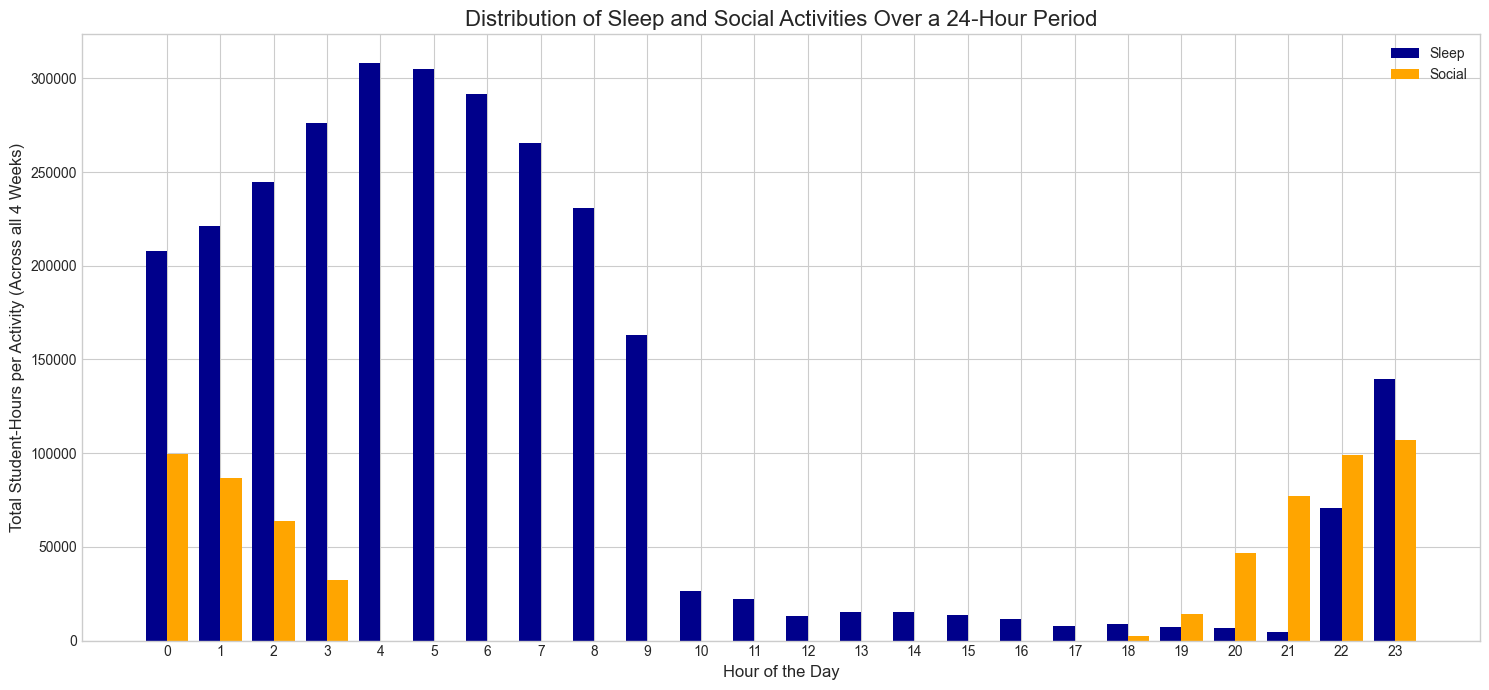


--- Analyzing Intra-Group Sleep Schedule Correlation ---

**Intra-Group Sleep Correlation Results:**
  - Average Standard Deviation of Bedtimes within a Group: 0.34 hours
  - Interpretation: LOW value, strong intra-group correlation.

--- Analyzing Group Social Sharing ---
  - Mean fraction of group social hours shared with at least one other group member: 22.60%
  - Median: 22.27%
  - 10th/90th percentiles: 18.20% / 27.64%


In [17]:
analyze_final_schedules('students_social_sleep_filled.csv')

Lecture hours per student (mean, min, max): 32.44965384278328 9 56
Canteen hours per student (mean, min, max): 34.93953203049689 10 53
Sleep hours per student (mean, min, max): 251.99956182630794 194 302
Social hours per student (mean, min, max): 55.06055560424152 24 117


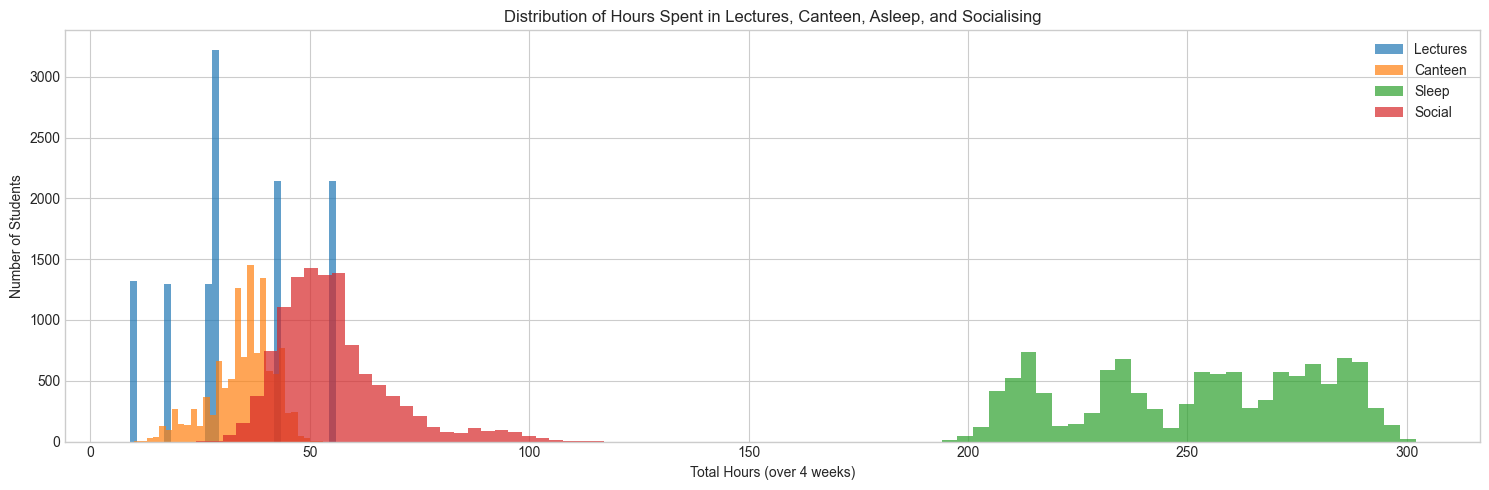

In [18]:

df = pd.read_csv('students_social_sleep_filled.csv')
time_cols = [col for col in df.columns if col.startswith('T_')]

# Count hours for each activity per student
def count_activity(row, keyword):
    return sum(keyword in str(val) for val in row[time_cols])

df['LectureHours'] = df[time_cols].apply(lambda row: count_activity(row, 'Lecture'), axis=1)
df['CanteenHours'] = df[time_cols].apply(lambda row: count_activity(row, 'Canteen'), axis=1)
df['SleepHours'] = df[time_cols].apply(lambda row: count_activity(row, 'Sleep'), axis=1)
df['SocialHours'] = df[time_cols].apply(lambda row: count_activity(row, 'Social'), axis=1)

# Print summary statistics
print("Lecture hours per student (mean, min, max):", df['LectureHours'].mean(), df['LectureHours'].min(), df['LectureHours'].max())
print("Canteen hours per student (mean, min, max):", df['CanteenHours'].mean(), df['CanteenHours'].min(), df['CanteenHours'].max())
print("Sleep hours per student (mean, min, max):", df['SleepHours'].mean(), df['SleepHours'].min(), df['SleepHours'].max())
print("Social hours per student (mean, min, max):", df['SocialHours'].mean(), df['SocialHours'].min(), df['SocialHours'].max())

# Plot distributions
plt.figure(figsize=(15,5))
plt.hist(df['LectureHours'], bins=30, alpha=0.7, label='Lectures')
plt.hist(df['CanteenHours'], bins=30, alpha=0.7, label='Canteen')
plt.hist(df['SleepHours'], bins=30, alpha=0.7, label='Sleep')
plt.hist(df['SocialHours'], bins=30, alpha=0.7, label='Social')
plt.xlabel('Total Hours (over 4 weeks)')
plt.ylabel('Number of Students')
plt.title('Distribution of Hours Spent in Lectures, Canteen, Asleep, and Socialising')
plt.legend()
plt.tight_layout()
plt.show()

We now have lectures, canteens, socials and sleep planned throughout the week. This just leaves 3 final 'types' to allocate - Outdoors, library and supermarket. <br>
Each student goes to the shops 1-3 times a week (normally distributed)<br>
The remaining 'Free' time of a student should be allocated to 20% 'Alone (Admin)' with a 5-40% of the remaining time being spent 'Outdoors' exercising, and then the rest of the time being spent in the 'Library'

In [19]:
#ALLOCATE SUPERMARKET, ALONE, OUTDOORS, LIBRARY
df = pd.read_csv('students_social_sleep_filled.csv')
time_cols = [col for col in df.columns if col.startswith('T_')]
schedule_arr = df[time_cols].values  # shape: (n_students, 672)
n_students = schedule_arr.shape[0]
n_hours = schedule_arr.shape[1]

np.random.seed(42)  # For reproducibility

for idx in range(n_students):
    # 1. Supermarket trips: 1-3 per week, only between 7:00–23:00
    free_indices = np.where(schedule_arr[idx] == 'Free')[0]
    n_trips = int(np.clip(np.round(np.random.normal(2, 0.5)), 1, 3))
    trip_hours = []
    for week in range(4):
        week_start = week * 7 * 24
        week_end = week_start + 7 * 24
        # Only allow supermarket between 7:00 and 23:00
        week_free = [h for h in free_indices if week_start <= h < week_end and 7 <= (h % 24) < 23]
        chosen = np.random.choice(week_free, min(n_trips, len(week_free)), replace=False) if len(week_free) >= n_trips else week_free
        trip_hours.extend(chosen)
    for h in trip_hours:
        schedule_arr[idx, h] = 'Supermarket'
    # Update free indices after supermarket allocation
    free_indices = np.where(schedule_arr[idx] == 'Free')[0]
    n_free = len(free_indices)
    if n_free == 0:
        continue

    # 2. Alone (Admin): 20% of remaining free time
    n_alone = int(round(n_free * 0.30))
    alone_indices = np.random.choice(free_indices, n_alone, replace=False) if n_alone > 0 else []
    schedule_arr[idx, alone_indices] = 'Alone (Life)'

    # 3. Outdoors: 5–40% of remaining free time, normal dist mean 15%
    free_indices = np.where(schedule_arr[idx] == 'Free')[0]
    outdoors_pct = np.clip(np.random.normal(0.25, 0.07), 0.05, 0.40)
    n_outdoors = int(round(len(free_indices) * outdoors_pct))
    outdoors_indices = np.random.choice(free_indices, n_outdoors, replace=False) if n_outdoors > 0 else []
    schedule_arr[idx, outdoors_indices] = 'Outdoors'

    # 4. Library: fill all remaining 'Free'
    free_indices = np.where(schedule_arr[idx] == 'Free')[0]
    schedule_arr[idx, free_indices] = 'Library'

# Assign back to DataFrame and save
df[time_cols] = schedule_arr
df.to_csv('students_full_timetable.csv', index=False)
print("Saved updated timetable with supermarket, alone, outdoors, and library to students_full_timetable.csv")

# Check that no 'Free' slots remain
assert (df[time_cols] == 'Free').sum().sum() == 0, "There are still 'Free' slots left!"
print("All 'Free' slots have been filled.")

Saved updated timetable with supermarket, alone, outdoors, and library to students_full_timetable.csv
All 'Free' slots have been filled.


In [20]:
def analyze_final_schedules(input_filename): 
    """
    Analyzes the final schedules for all activity distributions and
    investigates the correlation between group membership and sleep patterns,
    and group social sharing.
    """
    print(f"--- Loading final schedules from '{input_filename}' ---")
    try:
        df = pd.read_csv(input_filename)
        df['Group ID'] = pd.to_numeric(df['Group ID'], errors='coerce')
        print("File loaded successfully.")
    except FileNotFoundError:
        print(f"Error: Could not find '{input_filename}'. Please ensure the previous script has run successfully.")
        return

    time_slot_cols = [f'T_{i}' for i in range(672)]
    groups = df.groupby('Group ID').groups

    # --- 1. Analyze and Visualize All Activity Distributions ---
    print("\n--- Analyzing Distribution of All Activities per Hour ---")
    # Prepare long-form DataFrame for plotting
    schedule_long = df[time_slot_cols].unstack().reset_index()
    schedule_long.columns = ['TimeSlot', 'StudentIndex', 'Activity']
    schedule_long['HourOfDay'] = schedule_long['TimeSlot'].str.replace('T_', '').astype(int) % 24

    # Map all lecture/canteen variants to 'Lectures'/'Canteen'
    def canonical_activity(act):
        act = str(act)
        if 'lecture' in act.lower():
            return 'Lectures'
        if 'canteen' in act.lower():
            return 'Canteen'
        return act

    schedule_long['ActivityGroup'] = schedule_long['Activity'].map(canonical_activity)

    # Order for plotting
    activity_order = [
        'Sleep', 'Lectures', 'Canteen', 'Supermarket', 'Alone (Life)', 
        'Outdoors', 'Library', 'Social'
    ]
    # Add any missing activities to the order
    all_activities = pd.unique(schedule_long['ActivityGroup'])
    for act in all_activities:
        if act not in activity_order:
            activity_order.append(act)

    # Count occurrences of each activity per hour
    activity_counts = schedule_long.groupby(['HourOfDay', 'ActivityGroup']).size().unstack(fill_value=0)
    activity_counts = activity_counts[activity_order].fillna(0)

    # Plot stacked bar chart
    plt.figure(figsize=(18, 8))
    bottom = np.zeros(24)
    colors = {
        'Sleep': '#1f77b4', 'Lectures': '#ff7f0e', 'Canteen': '#2ca02c', 'Supermarket': '#9467bd',
        'Alone (Life)': '#8c564b', 'Outdoors': '#17becf', 'Library': '#d62728', 'Social': '#e377c2'
    }
    for activity in activity_order:
        if activity in activity_counts:
            plt.bar(
                activity_counts.index, 
                activity_counts[activity], 
                bottom=bottom, 
                label=activity, 
                color=colors.get(activity, None), 
                width=0.95
            )
            bottom += activity_counts[activity].values

    plt.xlabel('Hour of the Day')
    plt.ylabel('Total Student-Hours (All 4 Weeks)')
    plt.title('Distribution of All Activities Over a 24-Hour Period')
    plt.xticks(np.arange(24))
    plt.legend(loc='upper right', bbox_to_anchor=(1.18, 1))
    plt.tight_layout()
    plt.savefig('all_activity_distribution.png')
    print("Saved plot to all_activity_distribution.png")
    plt.show()

    # --- 2. Intra-Group Sleep Schedule Correlation (unchanged) ---
    print("\n--- Analyzing Intra-Group Sleep Schedule Correlation ---")
    arr = df[time_slot_cols].values
    bedtimes = np.full((arr.shape[0], 28), np.nan)
    for day in range(28):
        idxs = [(day*24 + i) % 672 for i in range(20, 30)]
        day_arr = arr[:, idxs]
        is_sleep = (day_arr == 'Sleep')
        first_sleep = np.argmax(is_sleep, axis=1)
        has_sleep = is_sleep.any(axis=1)
        bedtime = np.array([idxs[i] % 24 for i in first_sleep], dtype=float)     
        bedtime[(bedtime < 12) & has_sleep] += 24
        bedtimes[:, day] = bedtime

    avg_bedtime = np.nanmean(bedtimes, axis=1)
    df['avg_bedtime'] = avg_bedtime
    group_bedtime_std = df.groupby('Group ID')['avg_bedtime'].std().dropna()
    avg_std_across_groups = group_bedtime_std.mean()
    print("\n**Intra-Group Sleep Correlation Results:**")
    print(f"  - Average Standard Deviation of Bedtimes within a Group: {avg_std_across_groups:.2f} hours")
    if avg_std_across_groups < 1.0:
        print("  - Interpretation: LOW value, strong intra-group correlation.")
    elif avg_std_across_groups < 2.0:
        print("  - Interpretation: MODERATE value, good intra-group correlation.")
    else:
        print("  - Interpretation: HIGH value, weak intra-group correlation.")

    # --- 3. Group Social Sharing Analysis (unchanged) ---
    print("\n--- Analyzing Group Social Sharing ---")
    arr_int = np.zeros_like(arr, dtype=np.uint8)
    arr_int[df[time_slot_cols] == 'Sleep'] = 1
    arr_int[df[time_slot_cols] == 'Social'] = 2
    group_sharing = []
    for gid, indices in groups.items():
        if len(indices) < 2:
            continue
        group_arr = arr_int[list(indices)]
        social_overlap = np.sum(group_arr == 2, axis=0)
        shared_social_hours = np.sum(social_overlap >= 2)
        total_social_hours = np.sum(group_arr == 2)
        if total_social_hours > 0:
            sharing_frac = shared_social_hours / total_social_hours
            group_sharing.append(sharing_frac)
    if group_sharing:
        print(f"  - Mean fraction of group social hours shared with at least one other group member: {np.mean(group_sharing):.2%}")
        print(f"  - Median: {np.median(group_sharing):.2%}")
        print(f"  - 10th/90th percentiles: {np.percentile(group_sharing, 10):.2%} / {np.percentile(group_sharing, 90):.2%}")
    else:
        print("  - Not enough group data for social sharing analysis.")

--- Loading final schedules from 'students_full_timetable.csv' ---
File loaded successfully.

--- Analyzing Distribution of All Activities per Hour ---
Saved plot to all_activity_distribution.png


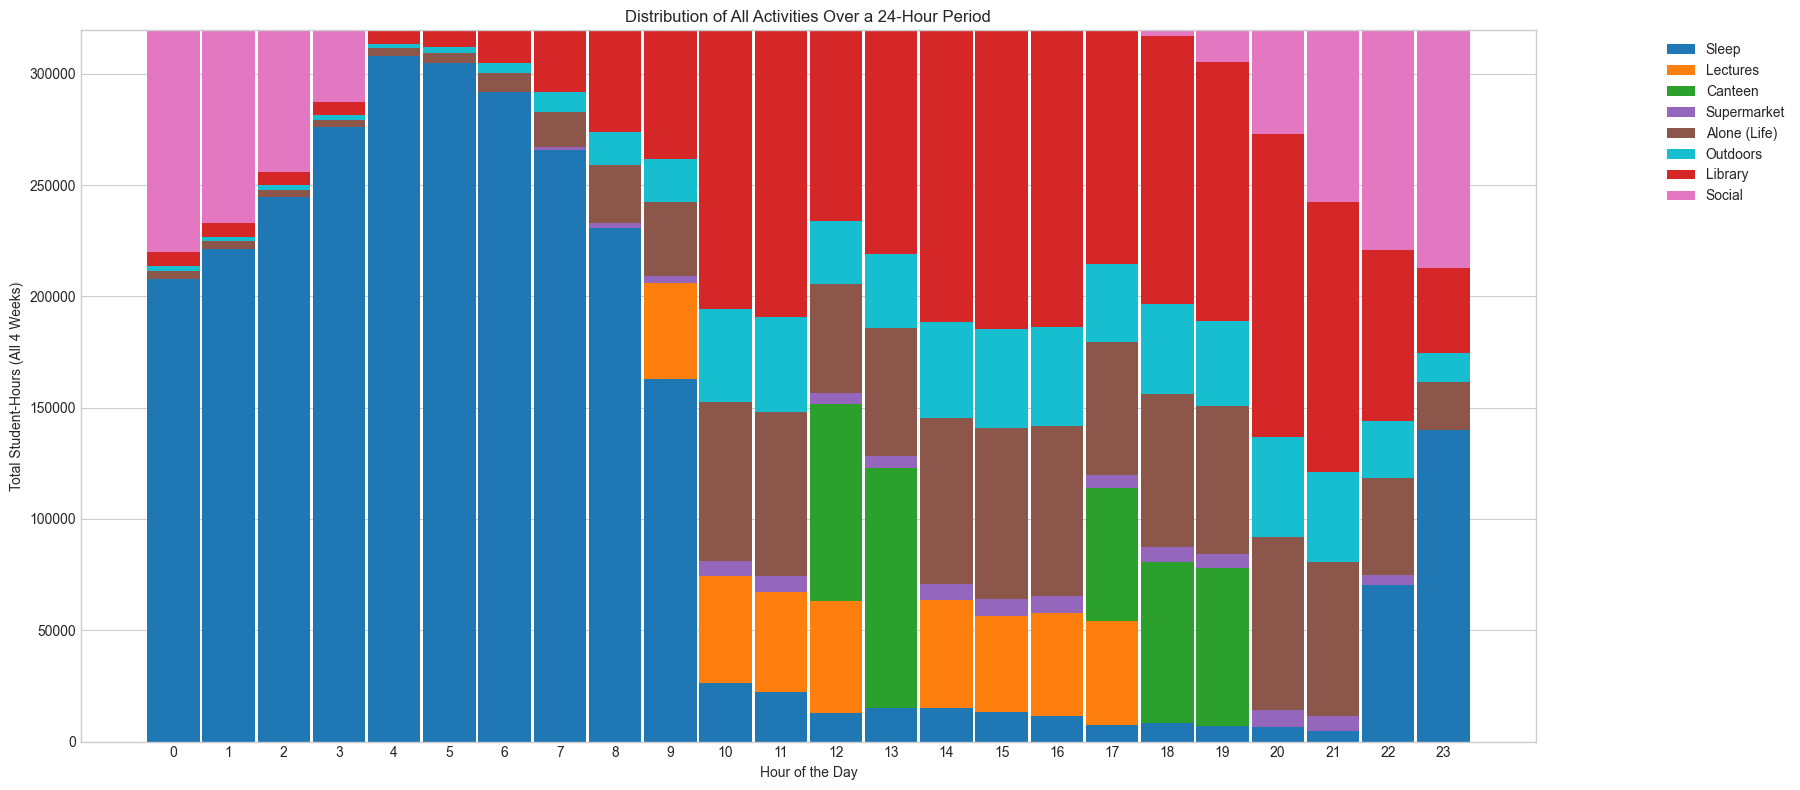


--- Analyzing Intra-Group Sleep Schedule Correlation ---

**Intra-Group Sleep Correlation Results:**
  - Average Standard Deviation of Bedtimes within a Group: 0.34 hours
  - Interpretation: LOW value, strong intra-group correlation.

--- Analyzing Group Social Sharing ---
  - Mean fraction of group social hours shared with at least one other group member: 22.60%
  - Median: 22.27%
  - 10th/90th percentiles: 18.20% / 27.64%


In [21]:
analyze_final_schedules('students_full_timetable.csv')

In [22]:
df = pd.read_csv('students_full_timetable.csv')
time_cols = [col for col in df.columns if col.startswith('T_')]

# Replace any entry containing 'canteen' (case-insensitive) with 'Canteen'
for col in time_cols:
    df[col] = df[col].apply(lambda x: 'Canteen' if isinstance(x, str) and 'canteen' in x.lower() else x)

df.to_csv('students_full_timetable.csv', index=False)
print("All 'canteen' entries replaced with 'Canteen' in students_full_timetable.csv")

All 'canteen' entries replaced with 'Canteen' in students_full_timetable.csv


In [23]:
# Supermarket allocation
df = pd.read_csv('students_full_timetable.csv')
locations = pd.read_csv('Location_location.csv')

# Get supermarket locations
supermarkets = locations[locations['Location Type'].str.lower() == 'supermarket']
supermarket_names = supermarkets['Name'].tolist()

# Map college to closest supermarket (excluding Sainsbury's (Sidney Street))
college_coords = locations[locations['Location Type'].str.lower() == 'college'][['Name', 'Latitude', 'Longitude']]
supermarket_coords = supermarkets[['Name', 'Latitude', 'Longitude']]

def closest_supermarket(college):
    c_row = college_coords[college_coords['Name'] == college]
    if c_row.empty:
        return "Sainsbury's (Sidney Street)"
    c_lat, c_lon = c_row.iloc[0][['Latitude', 'Longitude']]
    dists = ((supermarket_coords['Latitude'] - c_lat)**2 + (supermarket_coords['Longitude'] - c_lon)**2)
    # Use .loc with dists.idxmin() to avoid index mismatch
    return supermarket_coords.loc[dists.idxmin(), 'Name']

time_cols = [col for col in df.columns if col.startswith('T_')]
college_lookup = df['College'] if 'College' in df.columns else pd.read_csv('students_groups_social.csv')['College']

for idx, row in df.iterrows():
    college = college_lookup.iloc[idx]
    for col in time_cols:
        if row[col] == 'Supermarket':
            if college in ['Girton', 'Homerton']:
                # Always go to their nearest supermarket
                df.at[idx, col] = closest_supermarket(college)
            else:
                if np.random.rand() < 0.8:
                    df.at[idx, col] = "Sainsbury's (Sidney Street)"
                else:
                    df.at[idx, col] = closest_supermarket(college)

df.to_csv('students_full_timetable_supermarket.csv', index=False)
print("Supermarket locations assigned and saved to students_full_timetable_supermarket.csv")

Supermarket locations assigned and saved to students_full_timetable_supermarket.csv


In [24]:
#Canteen assignment
df = pd.read_csv('students_full_timetable_supermarket.csv')
locations = pd.read_csv('Location_location.csv')
canteens = locations[locations['Location Type'].str.lower() == 'canteen'].reset_index(drop=True)
students = pd.read_csv('students_groups_social.csv')

time_cols = [col for col in df.columns if col.startswith('T_')]
subject_lookup = students['Subject'].values
college_lookup = students['College'].values

# Precompute college canteen names
college_canteen_map = {college: f"{college} Canteen" for college in np.unique(college_lookup)}

# Precompute subject building coordinates for all subjects
subject_building_coords = {}
for subject in np.unique(subject_lookup):
    matches = locations[locations['Name'].str.contains(fr'\b{re.escape(subject)}\b', case=False, na=False, regex=True)]
    if not matches.empty:
        subject_building_coords[subject] = tuple(matches.iloc[0][['Latitude', 'Longitude']])
    else:
        subject_building_coords[subject] = (np.nan, np.nan)

# Helper: find canteen closest to a given lat/lon
def closest_canteen(lat, lon):
    dists = ((canteens['Latitude'] - lat)**2 + (canteens['Longitude'] - lon)**2)
    return canteens.loc[dists.idxmin(), 'Name']

# Precompute college coordinates for random nearby canteen fallback
college_coords = locations[locations['Location Type'].str.lower() == 'college'].set_index('Name')[['Latitude', 'Longitude']]

for idx in range(len(df)):
    college = college_lookup[idx]
    subject = subject_lookup[idx]
    subj_lat, subj_lon = subject_building_coords.get(subject, (np.nan, np.nan))
    college_canteen = college_canteen_map.get(college, f"{college} Canteen")
    # Get college coordinates for fallback
    if college in college_coords.index:
        c_lat, c_lon = college_coords.loc[college]
    else:
        c_lat, c_lon = np.nan, np.nan

    row = df.iloc[idx]
    prev_lecture = None
    for t, col in enumerate(time_cols):
        if row[col] == 'Canteen':
            prev = row[time_cols[t-1]] if t > 0 else ''
            if isinstance(prev, str) and 'lecture' in prev.lower():
                # 50% subject canteen, 50% college canteen
                if np.random.rand() < 0.5 and not np.isnan(subj_lat):
                    df.at[idx, col] = closest_canteen(subj_lat, subj_lon)
                else:
                    df.at[idx, col] = college_canteen
            else:
                # 95% college canteen, 5% random nearby canteen
                if np.random.rand() < 0.95:
                    df.at[idx, col] = college_canteen
                else:
                    if not np.isnan(c_lat):
                        dists = np.sqrt((canteens['Latitude'] - c_lat)**2 + (canteens['Longitude'] - c_lon)**2)
                        nearby = canteens[dists < 0.018]
                        if not nearby.empty:
                            df.at[idx, col] = np.random.choice(nearby['Name'])
                        else:
                            df.at[idx, col] = college_canteen
                    else:
                        df.at[idx, col] = college_canteen

df.to_csv('students_full_timetable_canteen.csv', index=False)
print("Canteen locations assigned and saved to students_full_timetable_canteen.csv")

Canteen locations assigned and saved to students_full_timetable_canteen.csv


In [25]:
locations = pd.read_csv('Location_location.csv')

# Use .str.lower() == 'cafe' to ensure all cafes are included regardless of case
cafes = locations[locations['Location Type'].str.lower() == 'caff']

print("Number of cafes loaded:", len(cafes))
print(cafes[['Name', 'Latitude', 'Longitude']].head(10))

Number of cafes loaded: 8
                      Name  Latitude  Longitude
220            Fitzbillies   52.2017     0.1190
221      The Copper Kettle   52.2047     0.1181
222  Bould Brothers Coffee   52.2036     0.1226
223                  Aromi   52.2046     0.1205
224     Hot Numbers Coffee   52.1916     0.1378
225                   Stir   52.2166     0.1378
226    Indigo Coffee House   52.2018     0.1232
227      Michaelhouse Cafe   52.2062     0.1187


In [26]:
# LIBRARY & CAFE ASSIGNMENT (updated for cafe allocation)
df = pd.read_csv('students_full_timetable_canteen.csv')
locations = pd.read_csv('Location_location.csv')
libraries = locations[locations['Location Type'].str.lower().str.contains('library')]
cafes = locations[locations['Location Type'].str.lower() == 'caff']
students = pd.read_csv('students_groups_social.csv')

time_cols = [col for col in df.columns if col.startswith('T_')]
year_lookup = students['Year'].values
college_lookup = students['College'].values
subject_lookup = students['Subject'].values

# Precompute subject library mapping for fast lookup (only for hours 8 <= h < 18)
subject_library_map = {}
for subject in np.unique(subject_lookup):
    subj_lib = libraries[libraries['Name'].str.contains(fr'\b{re.escape(subject)}\b', case=False, na=False, regex=True)]
    if not subj_lib.empty:
        subject_library_map[subject] = subj_lib.iloc[0]['Name']
    else:
        subject_library_map[subject] = None

# Assign a "room worker" percentage to each student (mean 10%, clipped 0-100%)
np.random.seed(42)
room_worker_pct = np.clip(np.random.normal(0.10, 0.05, len(df)), 0, 1)

# Precompute per-student library preferences for efficiency
prefer_college_arr = np.random.rand(len(df)) < 0.5
use_univ_arr = np.array([(year in [3, 4]) and (np.random.rand() < 0.1) for year in year_lookup])

# Precompute 20% cafe users
use_cafe_arr = np.random.rand(len(df)) < 0.2

# Precompute 3 nearest cafes for each college
college_coords = locations[locations['Location Type'].str.lower() == 'college'][['Name', 'Latitude', 'Longitude']]
cafe_coords = cafes[['Name', 'Latitude', 'Longitude']]
nearest_cafes_map = {}
for college in college_coords['Name']:
    c_row = college_coords[college_coords['Name'] == college]
    c_lat, c_lon = c_row.iloc[0][['Latitude', 'Longitude']]
    cafes_sorted = cafe_coords.copy()
    cafes_sorted['dist'] = ((cafes_sorted['Latitude'] - c_lat)**2 + (cafes_sorted['Longitude'] - c_lon)**2)
    nearest_cafes_map[college] = cafes_sorted.nsmallest(3, 'dist')['Name'].tolist()

import time
start_time = time.time()
slots_allocated = 0

for idx, row in df.iterrows():
    year = year_lookup[idx]
    college = college_lookup[idx]
    subject = subject_lookup[idx]
    prefer_college = prefer_college_arr[idx]
    use_univ = use_univ_arr[idx]
    subj_lib_name = subject_library_map.get(subject, None)
    room_pct = room_worker_pct[idx]
    use_cafe = use_cafe_arr[idx]
    # Find all library slots for this student (for possible cafe allocation)
    lib_slots = [t for t, col in enumerate(time_cols) if row[col] == 'Library']
    cafe_slots = []
    if use_cafe and len(lib_slots) > 0:
        # Only consider slots between 9 and 17 (inclusive)
        day_hours = [t for t in lib_slots if 9 <= (t % 24) < 17]
        n_cafe = int(np.round(0.5 * len(day_hours)))
        if n_cafe > 0:
            cafe_slots = np.random.choice(day_hours, n_cafe, replace=False)
    for t, col in enumerate(time_cols):
        if row[col] == 'Library':
            hour = t % 24
            if t in cafe_slots:
                # Assign to one of the 3 nearest cafes
                cafe_name = np.random.choice(nearest_cafes_map.get(college, cafes['Name'].tolist()))
                df.at[idx, col] = cafe_name
            # After 18:00 or before 8:00, only college library or room work
            elif hour < 8 or hour >= 18:
                if np.random.rand() < room_pct:
                    df.at[idx, col] = 'Own Room'
                else:
                    df.at[idx, col] = f"{college} Library"
            # University Library for 3rd/4th years, 9am-7pm, 10% chance
            elif use_univ and 9 <= hour < 19:
                df.at[idx, col] = 'University Library'
            # Subject library only 8:00-17:59, if not a room worker and not prefer_college
            elif subj_lib_name is not None and not prefer_college and np.random.rand() > room_pct:
                df.at[idx, col] = subj_lib_name
            # Otherwise, college library or room
            else:
                if np.random.rand() < room_pct:
                    df.at[idx, col] = 'Own Room'
                else:
                    df.at[idx, col] = f"{college} Library"
            slots_allocated += 1
            if slots_allocated % 100000 == 0:
                elapsed = time.time() - start_time
                print(f"{slots_allocated} library/cafe slots allocated in {elapsed:.1f} seconds...")

elapsed = time.time() - start_time
print(f"Library and cafe locations assigned and saved to students_full_timetable_library.csv")
print(f"Total slots allocated: {slots_allocated} in {elapsed:.1f} seconds")

df.to_csv('students_full_timetable_library.csv', index=False)

100000 library/cafe slots allocated in 3.2 seconds...
200000 library/cafe slots allocated in 6.2 seconds...
300000 library/cafe slots allocated in 9.1 seconds...
400000 library/cafe slots allocated in 11.9 seconds...
500000 library/cafe slots allocated in 14.9 seconds...
600000 library/cafe slots allocated in 17.8 seconds...
700000 library/cafe slots allocated in 20.6 seconds...
800000 library/cafe slots allocated in 23.6 seconds...
900000 library/cafe slots allocated in 26.6 seconds...
1000000 library/cafe slots allocated in 29.6 seconds...
1100000 library/cafe slots allocated in 32.4 seconds...
1200000 library/cafe slots allocated in 35.3 seconds...
1300000 library/cafe slots allocated in 38.1 seconds...
1400000 library/cafe slots allocated in 41.0 seconds...
1500000 library/cafe slots allocated in 44.0 seconds...
1600000 library/cafe slots allocated in 46.8 seconds...
1700000 library/cafe slots allocated in 49.7 seconds...
Library and cafe locations assigned and saved to students_fu

So now the day has been allocated into types - which is excellent. Now students must be assigned to locations. It is assumed that during a block activity the student does not move <br>
So far there are types: 'Sleep', 'Social', 'Canteen', '___ Lectures', 'Supermarket', 'Alone (Admin)', 'Outdoors' and 'Library'. '___ Lectures', 'Alone (Admin)', 'Sleep'  and 'Outdoors' will remain unchanged for now. In 'Location_location.csv' there is a list of 220 locations with their geographic location (see headers). Only 'Social', 'Canteen', 'Supermarket' and 'Library' will be updated to real world locations stored within this csv file. <br>
'Supermarket' is the easiest to distribute. There are 8 'Supermarket' in the csv - See Location Type column to find them. 80% of the time a student will pick to go to 'Sainsbury's (Sidney Street)' unless they are at Girton or Homerton Colleges. The other 20% of the time, the student chooses to go to the supermarket that is closest to their college. <Br>
'Canteen' - The student chooses the canteen closest to their Subject building format = {'Subject' & 'Lectures'} 50% of the time if their previous location was '___ 'Lectures'' else they go to their college canteen. If they were not at lectures, 90% of the time they eat in their college canteen, with 10% of the time going to a random canteen within 2km from the student. <br>
'Library' - there are 3 categories here, subject, college and university. Only 3rd and 4th years go to the 'University Library' - and only 10% of them ever do, but they spend all their library time from 9am to 19pm there, else they go to their college library. Some students prefer to go to their college library, and others to their subject library - either way, a student will go to the same library 90% of the time. There is assumed to be no students who go to other college's or subject's  libaries.<br>
We will leave the social allocation for now as it is more complicated and requires futher thought. <br>
For now, code up seperate cell's for each location specifying algorithm. Saving a new csv file, then opening it for the next one each time. <br>


Ok so its only social locations to be allocated now.  <br>
There are 3 main social spaces. College bars, Pubs and Clubs. Check that you can load all the college bars, the pubs and the clubs {Done} <br>
How to allocate 'Social' blocks to locations. One thing is sure, all members of the group who are 'Social' in this hour should be in the same location. Socialising for the night generally (75%) starts in a college bar if you're a first year, or a pub if 2-4th year. If the social extends to 11pm and beyond, the group will move to a club. 30% of groups move to a Club at 11pm, the remainders at midnight. College bars 95% of the time will be the groups majority college bar, otherwise it will be a random nearby one. Pubs will randomly be one of the 5 nearest pubs to the college of the group. Critically, once a group has set up in a college bar or pub, they will not move until either they go to sleep or a club. The location distribution of the club is more complicated, and will be updated later - for now, just replace 'Social' with 'Club'.

In [33]:
# SOCIAL ALLOCATION: PUB HOPPING, CLUB ENTRY AT 11/12/1AM, NO 'Social' LEFT

df = pd.read_csv('students_full_timetable_library.csv')
locations = pd.read_csv('Location_location.csv')
students = pd.read_csv('students_groups_social.csv')

college_bars = locations[
    locations['Location Type'].str.lower().str.contains('bar') |
    locations['Name'].str.lower().str.contains('bar')
].reset_index(drop=True)
pubs = locations[
    locations['Location Type'].str.lower().str.contains('pub') |
    locations['Name'].str.lower().str.contains('pub')
].reset_index(drop=True)
clubs = locations[
    locations['Location Type'].str.lower().str.contains('club') |
    locations['Name'].str.lower().str.contains('club')
].reset_index(drop=True)

time_cols = [col for col in df.columns if col.startswith('T_')]
group_lookup = students['Group ID'].values
year_lookup = students['Year'].values
college_lookup = students['College'].values

# Map group ID to student indices
group_to_indices = {}
for idx, gid in enumerate(group_lookup):
    if pd.notna(gid):
        group_to_indices.setdefault(gid, []).append(idx)

# Map college to its bar (majority bar)
college_bar_map = {}
for college in np.unique(college_lookup):
    matches = college_bars[college_bars['Name'].str.lower().str.contains(college.lower())]
    college_bar_map[college] = matches.iloc[0]['Name'] if not matches.empty else np.random.choice(college_bars['Name'])

# Precompute nearest 5 pubs for each college
college_coords = locations[locations['Location Type'].str.lower() == 'college'][['Name', 'Latitude', 'Longitude']]
pub_coords = pubs[['Name', 'Latitude', 'Longitude']]
nearest_pubs_map = {}
for college in college_coords['Name']:
    c_row = college_coords[college_coords['Name'] == college]
    c_lat, c_lon = c_row.iloc[0][['Latitude', 'Longitude']]
    pubs_sorted = pub_coords.copy()
    pubs_sorted['dist'] = ((pubs_sorted['Latitude'] - c_lat)**2 + (pubs_sorted['Longitude'] - c_lon)**2)
    nearest_pubs_map[college] = pubs_sorted.nsmallest(5, 'dist')['Name'].tolist()

schedule_arr = df[time_cols].values
student_group = students['Group ID'].values
student_year = students['Year'].values
student_college = students['College'].values

last_location = {}  # (gid, t-1): location
group_club_lock = {}  # gid: (club_name, start_t)
group_pubhop_lock = {}  # gid: (pub_name, t_start, t_end, club_name)
group_pubstay_lock = {} # gid: (pub_name, t_end, club_name)

from tqdm import tqdm

def pick_club(day_of_week):
    # Use actual club names from the CSV
    club_names = clubs['Name'].tolist()
    club_names_lower = [c.lower() for c in club_names]

    # Try to find key clubs by substring (case-insensitive)
    def find_club(substring):
        for i, name in enumerate(club_names_lower):
            if substring in name:
                return club_names[i]
        return None

    mash = find_club('mash') or np.random.choice(club_names)
    lola = find_club('lola') or np.random.choice(club_names)
    revs = find_club('rev') or np.random.choice(club_names)
    vinyl = find_club('vinyl') or np.random.choice(club_names)
    others = [c for c in club_names if c not in [mash, lola, revs, vinyl]]

    r = np.random.rand()
    if day_of_week == 4:  # Friday
        if r < 0.8:
            return mash
        else:
            choices = [lola, revs, vinyl] + others
            return np.random.choice(choices)
    elif day_of_week == 6:  # Sunday
        if r < 0.8:
            return lola
        else:
            choices = [mash, revs, vinyl] + others
            return np.random.choice(choices)
    elif day_of_week == 2:  # Wednesday
        if r < 0.9:
            return revs
        else:
            choices = [mash, lola, vinyl] + others
            return np.random.choice(choices)
    elif day_of_week == 3:  # Thursday
        if r < 0.5:
            return vinyl
        else:
            choices = [mash, lola, revs] + others
            return np.random.choice(choices)
    elif day_of_week in [0, 1, 5]:  # Mon, Tue, Sat
        if r < 0.3:
            return revs
        elif r < 0.6:
            return mash
        elif r < 0.9:
            return lola
        else:
            return vinyl
    else:
        return np.random.choice(club_names)

# ...existing code...

for t, col in enumerate(tqdm(time_cols, desc="Allocating social locations")):
    social_mask = schedule_arr[:, t] == 'Social'
    if not np.any(social_mask):
        continue
    group_ids = pd.Series(student_group[social_mask]).dropna().unique()
    for gid in group_ids:
        if pd.isna(gid):
            continue
        group_indices = np.where((student_group == gid) & social_mask)[0]
        if len(group_indices) == 0:
            continue
        years = student_year[group_indices]
        colleges = student_college[group_indices]
        majority_year = int(np.round(np.median(years)))
        majority_college = pd.Series(colleges).mode()[0]
        hour = t % 24
        day_of_week = (t // 24) % 7  # 0=Monday, 1=Tuesday, ..., 6=Sunday

        # --- PUB HOPPING LOGIC: 23:00–01:00, 50% chance to hop, 25% club at 23, 25% club at 0 ---
        # If in pub hopping lock
        if gid in group_pubhop_lock:
            pub_name, t_start, t_end, club_name = group_pubhop_lock[gid]
            if t_start <= t <= t_end:
                schedule_arr[group_indices, t] = pub_name
                last_location[(gid, t)] = pub_name
            elif t == t_end + 1:
                schedule_arr[group_indices, t] = club_name
                last_location[(gid, t)] = club_name
                group_club_lock[gid] = (club_name, t)
                del group_pubhop_lock[gid]
            continue

        # If in pub stay lock (stay at pub for one hour, then club)
        if gid in group_pubstay_lock:
            pub_name, t_end, club_name = group_pubstay_lock[gid]
            if t <= t_end:
                schedule_arr[group_indices, t] = pub_name
                last_location[(gid, t)] = pub_name
            elif t == t_end + 1:
                schedule_arr[group_indices, t] = club_name
                last_location[(gid, t)] = club_name
                group_club_lock[gid] = (club_name, t)
                del group_pubstay_lock[gid]
            continue

        # If in club lock
        if gid in group_club_lock:
            club_name, club_start_t = group_club_lock[gid]
            schedule_arr[group_indices, t] = club_name
            last_location[(gid, t)] = club_name
            # If any group member is not social in next hour, unlock
            if t + 1 < len(time_cols):
                next_social_mask = schedule_arr[group_indices, t + 1] == 'Social'
                if not np.any(next_social_mask):
                    del group_club_lock[gid]
            continue

        # --- PUB/PUB HOP/CLUB DECISION AT 23:00 ---
        if hour == 23:
            # Check if group was in a pub at 22:00 and will be social at 23:00 and 0:00 (and maybe 1:00)
            prev_loc = last_location.get((gid, t-1), None)
            next_social = (t+1 < len(time_cols)) and np.all(schedule_arr[group_indices, t+1] == 'Social')
            next2_social = (t+2 < len(time_cols)) and np.all(schedule_arr[group_indices, t+2] == 'Social')
            if prev_loc in pubs['Name'].values and next_social:
                r = np.random.rand()
                club_name = pick_club(day_of_week)
                pub_choices = nearest_pubs_map.get(majority_college, pubs['Name'].tolist())
                # 50%: move to another pub for 23:00, 0:00 (and maybe 1:00), then club
                if r < 0.5:
                    new_pub = np.random.choice([p for p in pub_choices if p != prev_loc] or pub_choices)
                    # If also social at 1:00, stay in pub for 3 hours, then club at 2:00
                    if next2_social and (t+2 < len(time_cols)):
                        group_pubhop_lock[gid] = (new_pub, t, t+2, club_name)
                    else:
                        group_pubhop_lock[gid] = (new_pub, t, t+1, club_name)
                    continue
                # 25%: go to club at 23:00
                elif r < 0.75:
                    schedule_arr[group_indices, t] = club_name
                    last_location[(gid, t)] = club_name
                    group_club_lock[gid] = (club_name, t)
                    continue
                # 25%: stay at current pub for one hour, then club at 0:00
                else:
                    group_pubstay_lock[gid] = (prev_loc, t, club_name)
                    continue

        # --- CLUB ENTRY AT 0:00 IF STILL SOCIAL ---
        if hour == 0:
            prev_loc = last_location.get((gid, t-1), None)
            if prev_loc in pubs['Name'].values:
                # If still social at 1:00, stay in pub for 1:00, then club at 2:00
                next_social = (t+1 < len(time_cols)) and np.all(schedule_arr[group_indices, t+1] == 'Social')
                club_name = pick_club(day_of_week)
                if next_social and (t+1 < len(time_cols)):
                    group_pubstay_lock[gid] = (prev_loc, t, club_name)
                    continue
                else:
                    schedule_arr[group_indices, t] = club_name
                    last_location[(gid, t)] = club_name
                    group_club_lock[gid] = (club_name, t)
                    continue

        # --- IF STILL SOCIAL AFTER 1:00, GO TO CLUB ---
        if hour == 1:
            prev_loc = last_location.get((gid, t-1), None)
            if prev_loc in pubs['Name'].values:
                club_name = pick_club(day_of_week)
                schedule_arr[group_indices, t] = club_name
                last_location[(gid, t)] = club_name
                group_club_lock[gid] = (club_name, t)
                continue

        # --- STICKINESS: 90% chance to stay in bar/pub if previous hour was bar/pub ---
        prev_loc = last_location.get((gid, t-1), None)
        if prev_loc is not None and prev_loc in list(college_bars['Name']) + list(pubs['Name']):
            if np.random.rand() < 0.9:
                schedule_arr[group_indices, t] = prev_loc
                last_location[(gid, t)] = prev_loc
                continue  # skip new allocation

        # --- BAR/PUB LOGIC ---
        if majority_year == 1 and np.random.rand() < 0.75:
            bar_name = college_bar_map.get(majority_college, np.random.choice(college_bars['Name']))
            if np.random.rand() >= 0.95:
                bar_name = np.random.choice(college_bars['Name'])
            schedule_arr[group_indices, t] = bar_name
            last_location[(gid, t)] = bar_name
        else:
            if np.random.rand() < 0.2:
                bar_name = college_bar_map.get(majority_college, np.random.choice(college_bars['Name']))
                schedule_arr[group_indices, t] = bar_name
                last_location[(gid, t)] = bar_name
            else:
                pub_choices = nearest_pubs_map.get(majority_college, pubs['Name'].tolist())
                pub_name = np.random.choice(pub_choices)
                schedule_arr[group_indices, t] = pub_name
                last_location[(gid, t)] = pub_name

# Ensure no 'Social' remains
for t in range(schedule_arr.shape[1]):
    mask = schedule_arr[:, t] == 'Social'
    if np.any(mask):
        # Assign any leftover 'Social' to 'Alone (Life)'
        schedule_arr[mask, t] = 'Alone (Life)'

df[time_cols] = schedule_arr
df.to_csv('students_full_timetable_social.csv', index=False)
print("Social locations assigned and saved to students_full_timetable_social.csv (pub hopping, club entry at 11/12/1am, no 'Social' left)")

Allocating social locations: 100%|██████████| 672/672 [00:35<00:00, 19.00it/s]


Social locations assigned and saved to students_full_timetable_social.csv (pub hopping, club entry at 11/12/1am, no 'Social' left)


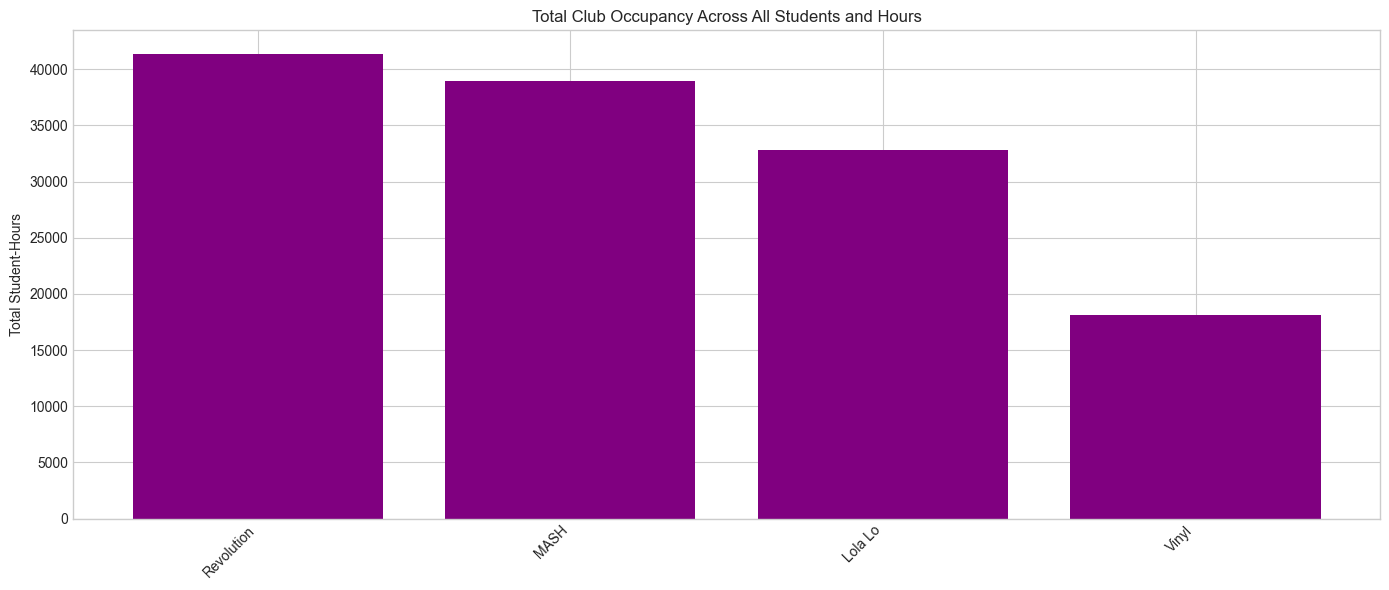

In [34]:

# Load the social timetable with club allocations
df = pd.read_csv('students_full_timetable_social.csv')
time_cols = [col for col in df.columns if col.startswith('T_')]

# Load club names from locations file
locations = pd.read_csv('Location_location.csv')
clubs = locations[
    locations['Location Type'].str.lower().str.contains('club') |
    locations['Name'].str.lower().str.contains('club')
].reset_index(drop=True)
club_names = clubs['Name'].tolist()

# Count club occupancies across all hours
club_counts = {club: 0 for club in club_names}
for col in time_cols:
    vals = df[col].value_counts()
    for club in club_names:
        club_counts[club] += vals.get(club, 0)

# Sort by occupancy
club_counts_sorted = dict(sorted(club_counts.items(), key=lambda x: x[1], reverse=True))

# Plot
plt.figure(figsize=(14, 6))
plt.bar(club_counts_sorted.keys(), club_counts_sorted.values(), color='purple')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Total Student-Hours')
plt.title('Total Club Occupancy Across All Students and Hours')
plt.tight_layout()
plt.show()

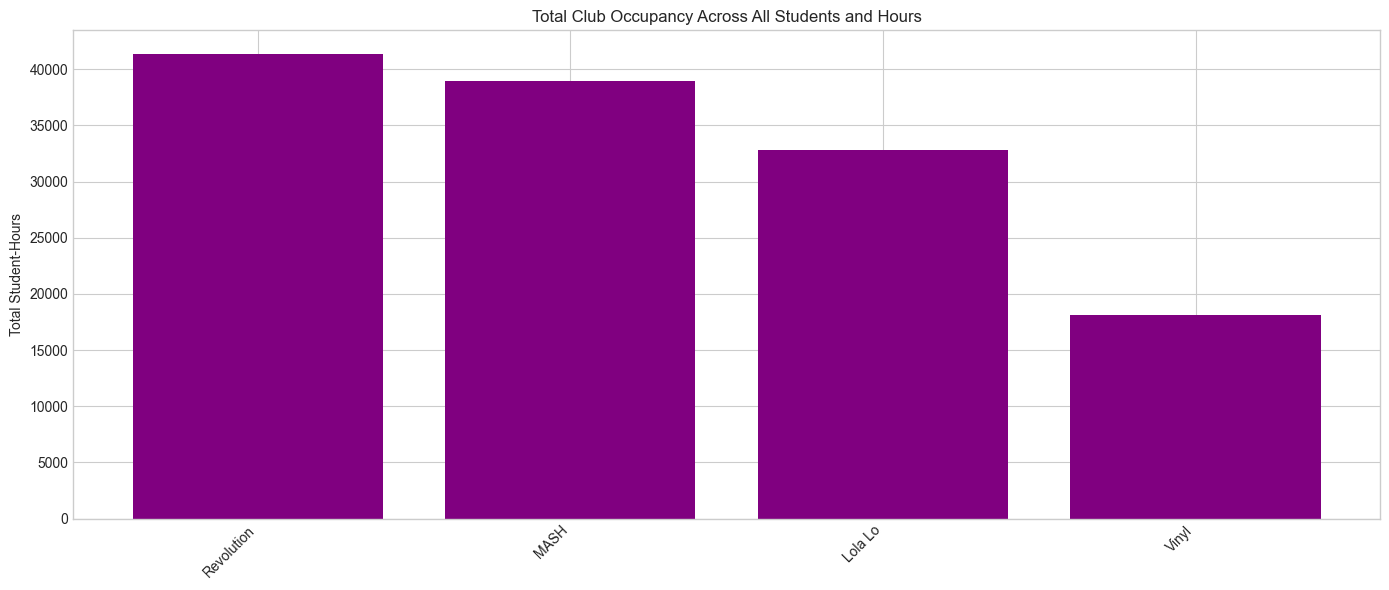

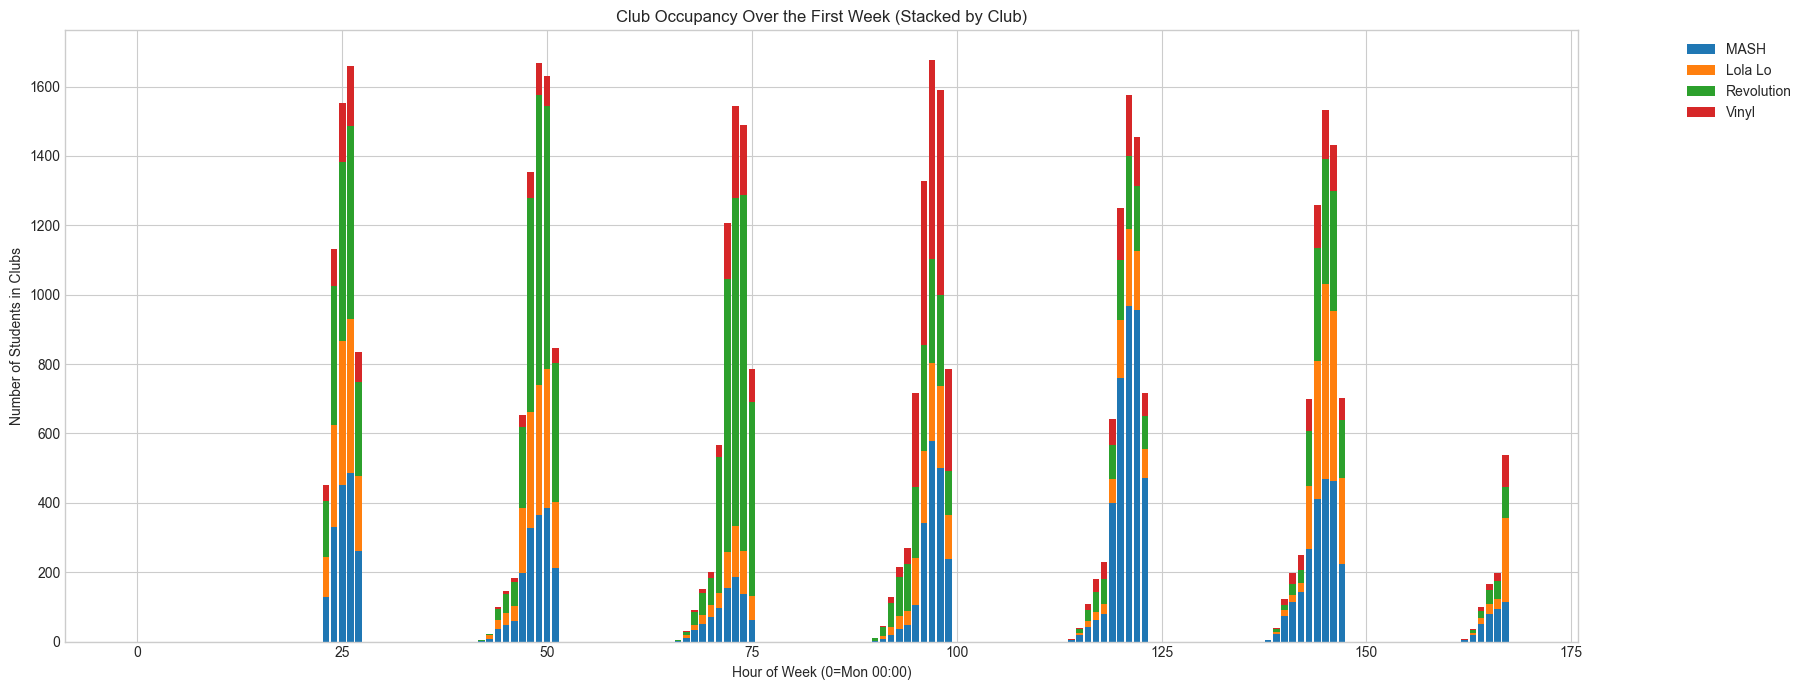

In [35]:
# Load the social timetable with club allocations
df = pd.read_csv('students_full_timetable_social.csv')
time_cols = [col for col in df.columns if col.startswith('T_')]

# Load club names from locations file
locations = pd.read_csv('Location_location.csv')
clubs = locations[
    locations['Location Type'].str.lower().str.contains('club') |
    locations['Name'].str.lower().str.contains('club')
].reset_index(drop=True)
club_names = clubs['Name'].tolist()

# --- Plot 1: Total club occupancy across all hours ---
club_counts = {club: 0 for club in club_names}
for col in time_cols:
    vals = df[col].value_counts()
    for club in club_names:
        club_counts[club] += vals.get(club, 0)

club_counts_sorted = dict(sorted(club_counts.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(14, 6))
plt.bar(club_counts_sorted.keys(), club_counts_sorted.values(), color='purple')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Total Student-Hours')
plt.title('Total Club Occupancy Across All Students and Hours')
plt.tight_layout()
plt.show()

# --- Plot 2: Club occupancy over a single week (168 hours) ---

# Pick the first week (hours 0 to 167)
week_cols = [f'T_{i}' for i in range(7*24)]
club_week_counts = {club: np.zeros(7*24, dtype=int) for club in club_names}

for h, col in enumerate(week_cols):
    vals = df[col].value_counts()
    for club in club_names:
        club_week_counts[club][h] = vals.get(club, 0)

# Plot as a stacked bar chart: x-axis is hour of week, y is number of students, stacked by club
plt.figure(figsize=(18, 7))
bottom = np.zeros(7*24)
for club in club_names:
    plt.bar(
        np.arange(7*24),
        club_week_counts[club],
        bottom=bottom,
        label=club
    )
    bottom += club_week_counts[club]

plt.xlabel('Hour of Week (0=Mon 00:00)')
plt.ylabel('Number of Students in Clubs')
plt.title('Club Occupancy Over the First Week (Stacked by Club)')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

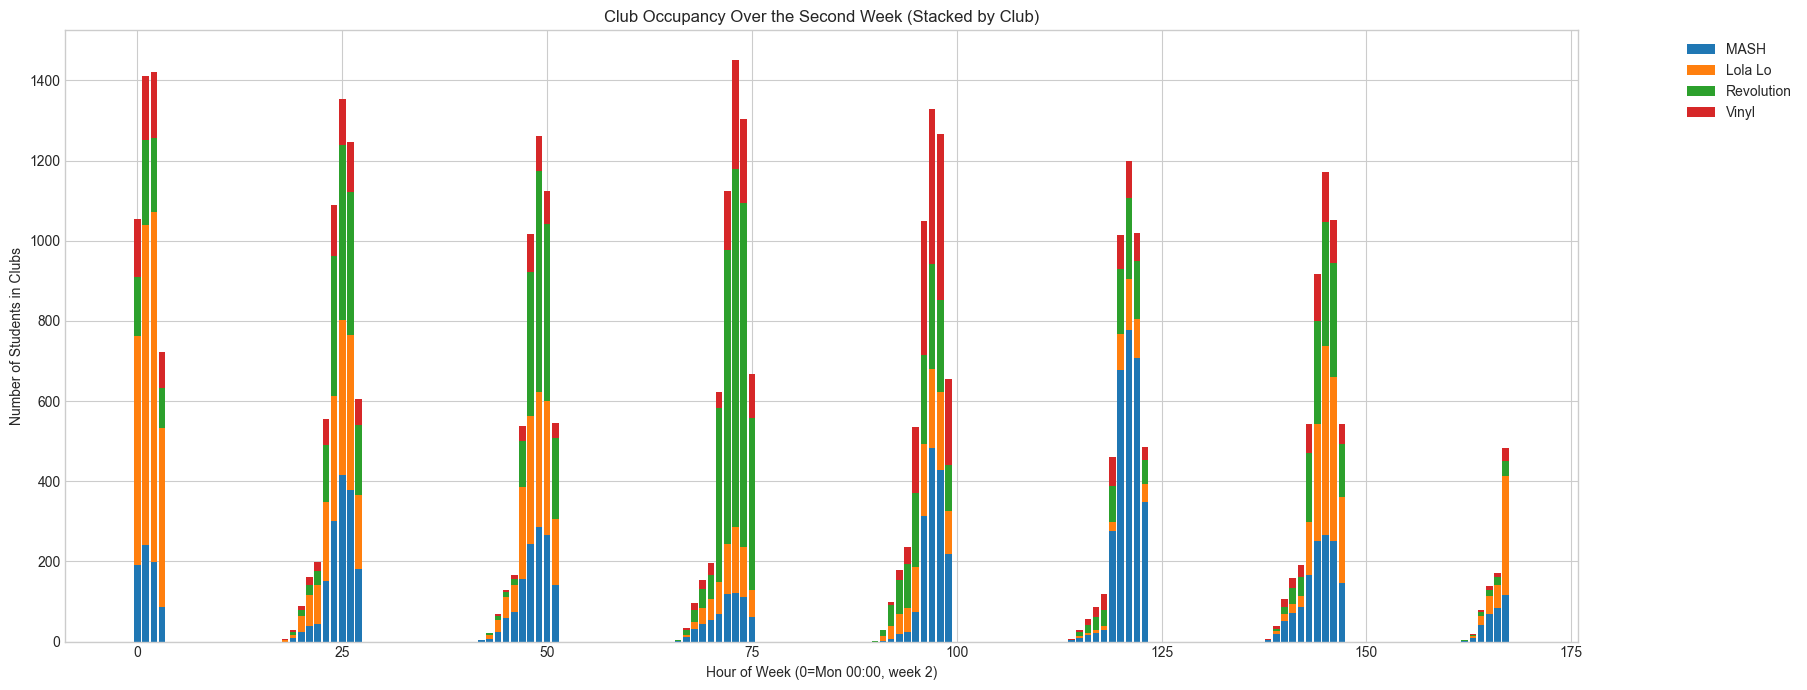

In [36]:
# --- Plot 2: Club occupancy over the SECOND week (hours 168 to 335) ---

# Pick the second week (hours 168 to 335)
week2_cols = [f'T_{i}' for i in range(7*24, 2*7*24)]
club_week2_counts = {club: np.zeros(7*24, dtype=int) for club in club_names}

for h, col in enumerate(week2_cols):
    vals = df[col].value_counts()
    for club in club_names:
        club_week2_counts[club][h] = vals.get(club, 0)

# Plot as a stacked bar chart: x-axis is hour of week, y is number of students, stacked by club
plt.figure(figsize=(18, 7))
bottom = np.zeros(7*24)
for club in club_names:
    plt.bar(
        np.arange(7*24),
        club_week2_counts[club],
        bottom=bottom,
        label=club
    )
    bottom += club_week2_counts[club]

plt.xlabel('Hour of Week (0=Mon 00:00, week 2)')
plt.ylabel('Number of Students in Clubs')
plt.title('Club Occupancy Over the Second Week (Stacked by Club)')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

In [37]:
df.to_csv('ColocCotime_network_base.csv', index=False)
print("Saved timetable as ColocCotime_network_base.csv")

Saved timetable as ColocCotime_network_base.csv


END OF THIS NOTEBOOK

We now have a complete set of mostly realistic schedules from which to generate a co-temporal, co-location disease spreading model.